# Gap Closure Scores Evaluation

This notebook computes gap closure metrics for both **short** and **kidmode** modes:
- **Short**: Measures response word count statistics
- **Kidmode**: Uses LLM-as-judge to score kid-friendliness

For each mode, we evaluate 6 sources:
1. Base model inference
2. Neologism inference
3. Combined neologism inference
4. Fine-tuning inference
5. Prompting inference
6. Training data

In [ ]:
"""
Gap Closure Scores Evaluation
"""

import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import random
import os

# OpenAI installs (for kidmode LLM-as-judge)
%pip install openai

from openai import OpenAI
import re

In [ ]:
# API Key for kidmode LLM-as-judge
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Initialize OpenAI client
client = OpenAI(api_key=OPENAI_API_KEY)

## File Paths Configuration

In [ ]:
# ============================================================================
# FILE PATHS
# ============================================================================

# Base model inference
BASE_MODEL_FILE = "../inference/base/base_mistral_inference_results.jsonl"

# Short mode files
SHORT_NEOLOGISM_FILE = "../inference/neologism/short/mistral_with_short_inference_results.jsonl"
SHORT_COMBINED_FILE = "../inference/composition_inference_results.jsonl"
SHORT_FINETUNING_FILE = "../inference/fine-tuning/short_rank8_inference_results.jsonl"
SHORT_PROMPTING_FILE = "../inference/prompting/prompting_short_inference.jsonl"
SHORT_TRAINING_FILE = "../data-prep/short/short_neologism.jsonl"

# Kidmode files
KIDMODE_NEOLOGISM_FILE = "../inference/neologism/kidmode/mistral_with_kidmode_inference_results.jsonl"
KIDMODE_COMBINED_FILE = "../inference/composition_inference_results.jsonl"
KIDMODE_FINETUNING_FILE = "../inference/fine-tuning/kidmode_rank8_inference_results.jsonl"
KIDMODE_PROMPTING_FILE = "../inference/prompting/prompting_kidmode_inference.jsonl"
KIDMODE_TRAINING_FILE = "../data-prep/kidmode/kidmode_neologism.jsonl"

# Sample size for scoring (to save costs)
SAMPLE_SIZE = 300

---
# Part 1: Short Mode - Response Word Count Statistics
---

In [ ]:
def compute_length_stats(filepath, response_key='response', sample_size=SAMPLE_SIZE):
    """
    Load a JSONL file and compute response word count statistics.
    
    Args:
        filepath: Path to JSONL file
        response_key: Key for response in JSONL (default 'response', 'chosen' for training data)
        sample_size: Number of examples to sample
    
    Returns:
        Dictionary with word count statistics
    """
    print(f"Loading {filepath}...")
    
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    
    print(f"  Loaded {len(data)} examples")
    
    # Sample if needed
    if len(data) > sample_size:
        print(f"  Sampling {sample_size} examples")
        sampled_data = random.sample(data, sample_size)
    else:
        sampled_data = data
    
    # Compute word counts
    word_counts = []
    for ex in sampled_data:
        response = ex.get(response_key, ex.get('chosen', ''))
        if response:
            # Split on whitespace to count words
            word_counts.append(len(response.split()))
    
    stats_dict = {
        'mean': float(np.mean(word_counts)),
        'median': float(np.median(word_counts)),
        'std': float(np.std(word_counts)),
        'min': float(np.min(word_counts)),
        'max': float(np.max(word_counts)),
        'count': len(word_counts),
        'word_counts': word_counts
    }
    
    print(f"  Mean word count: {stats_dict['mean']:.2f} (std: {stats_dict['std']:.2f})\n")
    
    return stats_dict

In [ ]:
# ============================================================================
# COMPUTE SHORT WORD COUNT STATISTICS
# ============================================================================

print("="*70)
print("SHORT MODE - RESPONSE WORD COUNT STATISTICS")
print("="*70 + "\n")

short_results = {}

# 1. Base model
print("### BASE MODEL ###")
print("-" * 40)
short_results['base_model'] = compute_length_stats(BASE_MODEL_FILE)

# 2. Neologism
print("### NEOLOGISM ###")
print("-" * 40)
short_results['neologism'] = compute_length_stats(SHORT_NEOLOGISM_FILE)

# 3. Combined Neologism
print("### COMBINED NEOLOGISM ###")
print("-" * 40)
short_results['combined_neologism'] = compute_length_stats(SHORT_COMBINED_FILE)

# 4. Fine-tuning
print("### FINE-TUNING ###")
print("-" * 40)
short_results['finetuning'] = compute_length_stats(SHORT_FINETUNING_FILE)

# 5. Prompting
print("### PROMPTING ###")
print("-" * 40)
short_results['prompting'] = compute_length_stats(SHORT_PROMPTING_FILE)

# 6. Training data
print("### TRAINING DATA ###")
print("-" * 40)
short_results['training_data'] = compute_length_stats(SHORT_TRAINING_FILE, response_key='chosen')

In [ ]:
# ============================================================================
# SHORT RESULTS SUMMARY
# ============================================================================

print("\n" + "="*70)
print("SHORT MODE - WORD COUNT STATISTICS SUMMARY")
print("="*70)

print(f"\n{'Method':<25} {'Mean':>10} {'Median':>10} {'Std':>10} {'Min':>8} {'Max':>8} {'N':>6}")
print("-"*77)

for name, stats_dict in short_results.items():
    print(f"{name:<25} {stats_dict['mean']:>10.2f} {stats_dict['median']:>10.2f} {stats_dict['std']:>10.2f} {stats_dict['min']:>8.0f} {stats_dict['max']:>8.0f} {stats_dict['count']:>6}")

print("="*77)

In [30]:
# ============================================================================
# SAVE SHORT STATISTICS TO JSON
# ============================================================================

# Prepare results for saving (without individual word counts to keep file small)
short_results_summary = {}
for name, stats_dict in short_results.items():
    short_results_summary[name] = {k: v for k, v in stats_dict.items() if k != 'word_counts'}

with open('short_statistics.json', 'w') as f:
    json.dump(short_results_summary, f, indent=2)

print("Short statistics saved to short_statistics.json")

Short statistics saved to short_statistics.json


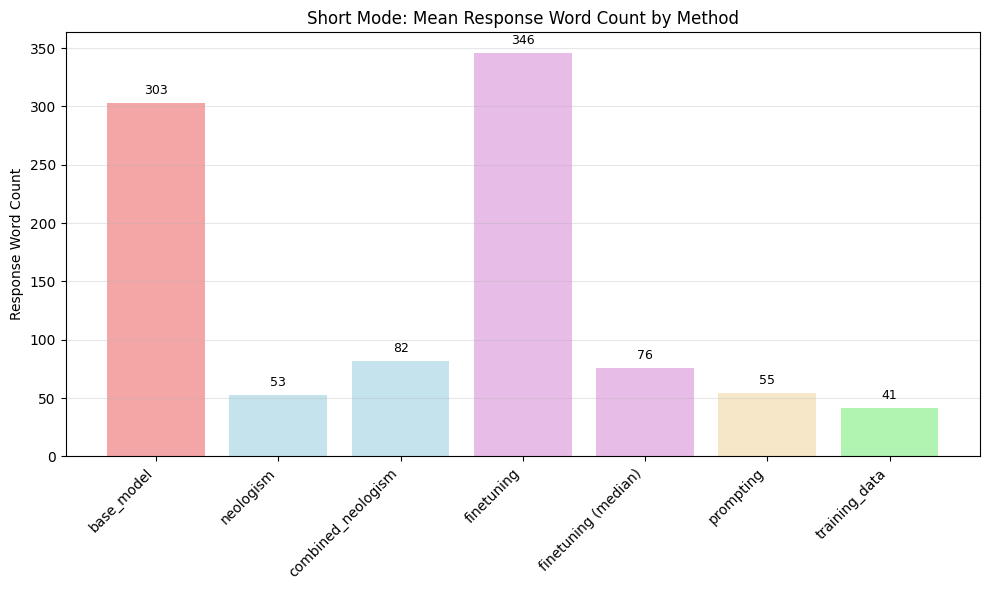


Bar chart saved to short_word_count_visualization.png


In [36]:
# ============================================================================
# SHORT VISUALIZATIONS
# ============================================================================

# Bar chart of mean word counts
fig1, ax1 = plt.subplots(figsize=(10, 6))

names = list(short_results.keys())
means = [short_results[n]['mean'] for n in names]

# Insert finetuning (median) right after finetuning
finetuning_idx = names.index('finetuning')
names.insert(finetuning_idx + 1, 'finetuning (median)')
means.insert(finetuning_idx + 1, short_results['finetuning']['median'])

# Color by category
colors = []
for name in names:
    if 'base' in name:
        colors.append('lightcoral')
    elif 'training' in name:
        colors.append('lightgreen')
    elif 'neologism' in name:
        colors.append('lightblue')
    elif 'finetuning' in name:
        colors.append('plum')
    elif 'prompting' in name:
        colors.append('wheat')
    else:
        colors.append('gray')

bars = ax1.bar(range(len(names)), means, color=colors, alpha=0.7)

ax1.set_xticks(range(len(names)))
ax1.set_xticklabels(names, rotation=45, ha='right')
ax1.set_ylabel('Response Word Count')
ax1.set_title('Short Mode: Mean Response Word Count by Method')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, mean in zip(bars, means):
    ax1.text(bar.get_x() + bar.get_width()/2., mean + 5,
            f'{mean:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('short_word_count_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nBar chart saved to short_word_count_visualization.png")

/var/folders/6y/br3yjb993pscjxzwdc284fqr0000gp/T/ipykernel_77760/2056716572.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=box_names, patch_artist=True, showfliers=False)


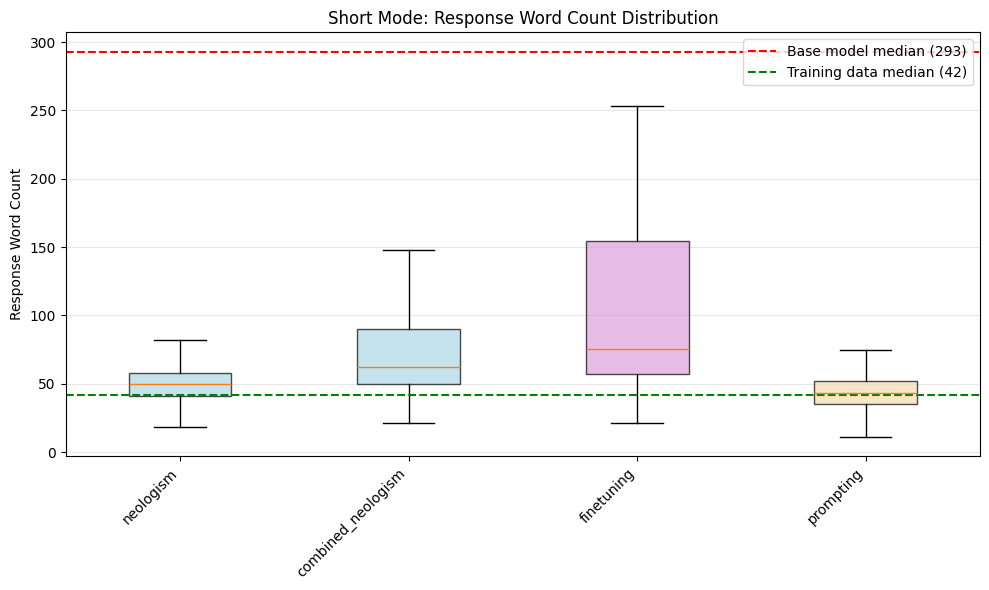


Box plot saved to short_word_count_boxplot.png


In [24]:
# Box and whisker plot
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Use only the methods (exclude base_model and training_data)
box_names = [n for n in short_results.keys() if n not in ['base_model', 'training_data']]
box_colors = []
for name in box_names:
    if 'neologism' in name:
        box_colors.append('lightblue')
    elif 'finetuning' in name:
        box_colors.append('plum')
    elif 'prompting' in name:
        box_colors.append('wheat')
    else:
        box_colors.append('gray')

box_data = [short_results[n]['word_counts'] for n in box_names]
bp = ax2.boxplot(box_data, labels=box_names, patch_artist=True, showfliers=False)

# Color the boxes
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add horizontal reference lines for base model and training data medians
ax2.axhline(y=short_results['base_model']['median'], color='red', linestyle='--', linewidth=1.5, label=f"Base model median ({short_results['base_model']['median']:.0f})")
ax2.axhline(y=short_results['training_data']['median'], color='green', linestyle='--', linewidth=1.5, label=f"Training data median ({short_results['training_data']['median']:.0f})")

ax2.set_xticklabels(box_names, rotation=45, ha='right')
ax2.set_ylabel('Response Word Count')
ax2.set_title('Short Mode: Response Word Count Distribution')
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('short_word_count_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nBox plot saved to short_word_count_boxplot.png")

---
# Part 2: Kidmode - LLM-as-Judge Kid-Friendliness Scores
---

In [25]:
# ============================================================================
# LLM-AS-JUDGE FUNCTION FOR KIDMODE
# Copied from: evals/kidmode/gap closure score/kidmode (prompting)/kidmode prompting score generation.ipynb
# ============================================================================

def judge_kidmode_score(instruction, response):
    """
    Score a response for kid-friendliness using LLM-as-judge (OpenAI).
    Returns score from 1-10.
    """
    
    judging_prompt = f"""Rate how KID-FRIENDLY and APPROACHABLE this response is on a scale from 1-10. 

A score of 10 means: 
- An approachable, instructional tone and patient demeanor toward the user
- Extremely simple vocabulary and sentence structure with no technical jargon
- Explanations and analogies that assume no prior knowledge about the topic
- Shorter responses (<200-250 words)

A score of 1 means: 
- Reliance on long sentences with highly technical language / academic jargon
- Formal tone
- Communication of complex concepts
- Long responses (>400 words)

Examples:
Score 9-10: "Brain cells are like tiny workers in your head! They mostly stay in one place once they find their spot, kind of like how you have your own desk at school. When you're a baby, some brain cells do move around to find the perfect place to work, but once they're settled, they stay put."

Score 1-3: "The question of neuronal migration necessitates understanding the dynamic spatiotemporal regulation of cytoskeletal reorganization and chemoattractant gradients during cortical lamination..."

Instruction: {instruction}

Response: {response}

Provide ONLY a single number from 1-10, with no explanation:"""
    
    completion = client.chat.completions.create(
        model="gpt-4o-mini", 
        messages=[
            {"role": "user", "content": judging_prompt}
        ],
        max_tokens=10,
        temperature=0
    )
    
    score_text = completion.choices[0].message.content.strip()
    
    # Extract number
    match = re.search(r'\d+', score_text)
    if match:
        score = float(match.group())
        return min(max(score, 1), 10)  # Clamp to [1, 10]
    else:
        raise ValueError(f"Could not parse score from: {score_text}")

In [26]:
def compute_kidmode_scores(filepath, response_key='response', prompt_key='prompt', sample_size=SAMPLE_SIZE):
    """
    Load a JSONL file and compute kidmode scores using LLM-as-judge.
    
    Args:
        filepath: Path to JSONL file
        response_key: Key for response in JSONL (default 'response', 'chosen' for training data)
        prompt_key: Key for prompt/instruction in JSONL
        sample_size: Number of examples to score
    
    Returns:
        Dictionary with kidmode statistics
    """
    print(f"Loading {filepath}...")
    
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    
    print(f"  Loaded {len(data)} examples")
    
    # Sample if needed
    if len(data) > sample_size:
        print(f"  Sampling {sample_size} examples for scoring")
        sampled_data = random.sample(data, sample_size)
    else:
        sampled_data = data
    
    print(f"  Scoring {len(sampled_data)} examples with LLM judge...")
    print("  (This may take several minutes...)")
    
    scores = []
    for i, ex in enumerate(sampled_data):
        try:
            prompt = ex.get(prompt_key, ex.get('instruction', ''))
            response = ex.get(response_key, ex.get('chosen', ''))
            
            score = judge_kidmode_score(prompt, response)
            scores.append(score)
            
            if (i + 1) % 20 == 0:
                print(f"    Progress: {i+1}/{len(sampled_data)} | Current avg: {np.mean(scores):.2f}")
        except Exception as e:
            print(f"    Warning: Failed to score example {i}: {e}")
            continue
    
    stats_dict = {
        'mean': float(np.mean(scores)),
        'median': float(np.median(scores)),
        'std': float(np.std(scores)),
        'min': float(np.min(scores)),
        'max': float(np.max(scores)),
        'count': len(scores),
        'scores': scores
    }
    
    print(f"  Mean score: {stats_dict['mean']:.2f} (std: {stats_dict['std']:.2f})\n")
    
    return stats_dict

In [27]:
# ============================================================================
# COMPUTE KIDMODE SCORES
# ============================================================================

print("="*70)
print("KIDMODE - LLM-AS-JUDGE KID-FRIENDLINESS SCORES")
print("="*70 + "\n")

kidmode_results = {}

# 1. Base model
print("### BASE MODEL ###")
print("-" * 40)
kidmode_results['base_model'] = compute_kidmode_scores(BASE_MODEL_FILE)

# 2. Neologism
print("### NEOLOGISM ###")
print("-" * 40)
kidmode_results['neologism'] = compute_kidmode_scores(KIDMODE_NEOLOGISM_FILE)

# 3. Combined Neologism
print("### COMBINED NEOLOGISM ###")
print("-" * 40)
kidmode_results['combined_neologism'] = compute_kidmode_scores(KIDMODE_COMBINED_FILE)

# 4. Fine-tuning
print("### FINE-TUNING ###")
print("-" * 40)
kidmode_results['finetuning'] = compute_kidmode_scores(KIDMODE_FINETUNING_FILE)

# 5. Prompting
print("### PROMPTING ###")
print("-" * 40)
kidmode_results['prompting'] = compute_kidmode_scores(KIDMODE_PROMPTING_FILE)

# 6. Training data
print("### TRAINING DATA ###")
print("-" * 40)
kidmode_results['training_data'] = compute_kidmode_scores(KIDMODE_TRAINING_FILE, response_key='chosen')

KIDMODE - LLM-AS-JUDGE KID-FRIENDLINESS SCORES

### BASE MODEL ###
----------------------------------------
Loading ../inference/base/base_mistral_inference_results.jsonl...
  Loaded 300 examples
  Scoring 300 examples with LLM judge...
  (This may take several minutes...)
    Progress: 20/300 | Current avg: 3.00
    Progress: 40/300 | Current avg: 3.15
    Progress: 60/300 | Current avg: 3.15
    Progress: 80/300 | Current avg: 3.17
    Progress: 100/300 | Current avg: 3.21
    Progress: 120/300 | Current avg: 3.14
    Progress: 140/300 | Current avg: 3.06
    Progress: 160/300 | Current avg: 2.97
    Progress: 180/300 | Current avg: 2.97
    Progress: 200/300 | Current avg: 3.04
    Progress: 220/300 | Current avg: 3.10
    Progress: 240/300 | Current avg: 3.10
    Progress: 260/300 | Current avg: 3.04
    Progress: 280/300 | Current avg: 3.02
    Progress: 300/300 | Current avg: 3.00
  Mean score: 3.00 (std: 1.54)

### NEOLOGISM ###
----------------------------------------
Loading .

In [29]:
# ============================================================================
# SAVE KIDMODE STATISTICS TO JSON
# ============================================================================

# Prepare results for saving (without individual word counts to keep file small)
kidmode_results_summary = {}
for name, stats_dict in kidmode_results.items():
    kidmode_results_summary[name] = {k: v for k, v in stats_dict.items() if k != 'word_counts'}

with open('kidmode_statistics.json', 'w') as f:
    json.dump(kidmode_results_summary, f, indent=2)

print("Kidmode statistics saved to kidmode_statistics.json")

Kidmode statistics saved to kidmode_statistics.json


In [31]:
# ============================================================================
# KIDMODE RESULTS SUMMARY
# ============================================================================

print("\n" + "="*70)
print("KIDMODE - KID-FRIENDLINESS SCORE SUMMARY")
print("="*70)

print(f"\n{'Method':<25} {'Mean':>10} {'Median':>10} {'Std':>10} {'Min':>8} {'Max':>8} {'N':>6}")
print("-"*77)

for name, stats_dict in kidmode_results.items():
    print(f"{name:<25} {stats_dict['mean']:>10.2f} {stats_dict['median']:>10.2f} {stats_dict['std']:>10.2f} {stats_dict['min']:>8.0f} {stats_dict['max']:>8.0f} {stats_dict['count']:>6}")

print("="*77)


KIDMODE - KID-FRIENDLINESS SCORE SUMMARY

Method                          Mean     Median        Std      Min      Max      N
-----------------------------------------------------------------------------
base_model                      3.00       3.00       1.54        1       10    300
neologism                       6.15       6.00       2.20        1       10    300
combined_neologism              4.06       4.00       1.82        1       10    300
finetuning                      5.74       6.00       2.42        1       10    300
prompting                       6.90       8.00       2.29        1       10    300
training_data                   7.55       8.00       2.06        1       10    300


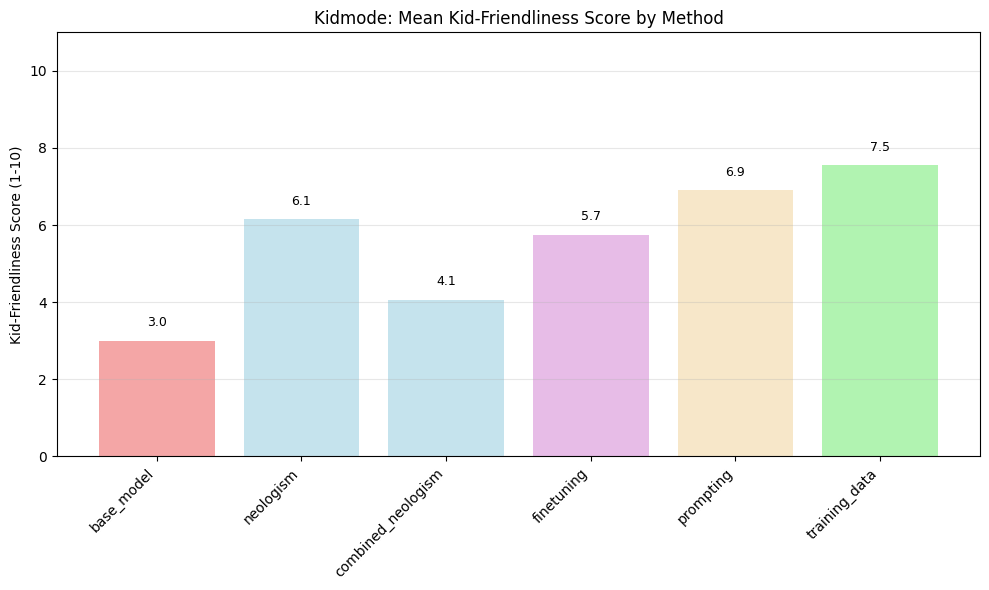


Bar chart saved to kidmode_score_visualization.png


In [32]:
# ============================================================================
# KIDMODE VISUALIZATIONS
# ============================================================================

# Bar chart of mean scores
fig1, ax1 = plt.subplots(figsize=(10, 6))

names = list(kidmode_results.keys())
means = [kidmode_results[n]['mean'] for n in names]

# Color by category
colors = []
for name in names:
    if 'base' in name:
        colors.append('lightcoral')
    elif 'training' in name:
        colors.append('lightgreen')
    elif 'neologism' in name:
        colors.append('lightblue')
    elif 'finetuning' in name:
        colors.append('plum')
    elif 'prompting' in name:
        colors.append('wheat')
    else:
        colors.append('gray')

bars = ax1.bar(range(len(names)), means, color=colors, alpha=0.7)

ax1.set_xticks(range(len(names)))
ax1.set_xticklabels(names, rotation=45, ha='right')
ax1.set_ylabel('Kid-Friendliness Score (1-10)')
ax1.set_title('Kidmode: Mean Kid-Friendliness Score by Method')
ax1.set_ylim(0, 11)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, mean in zip(bars, means):
    ax1.text(bar.get_x() + bar.get_width()/2., mean + 0.3,
            f'{mean:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('kidmode_score_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nBar chart saved to kidmode_score_visualization.png")

/var/folders/6y/br3yjb993pscjxzwdc284fqr0000gp/T/ipykernel_77760/646291325.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=names, patch_artist=True)


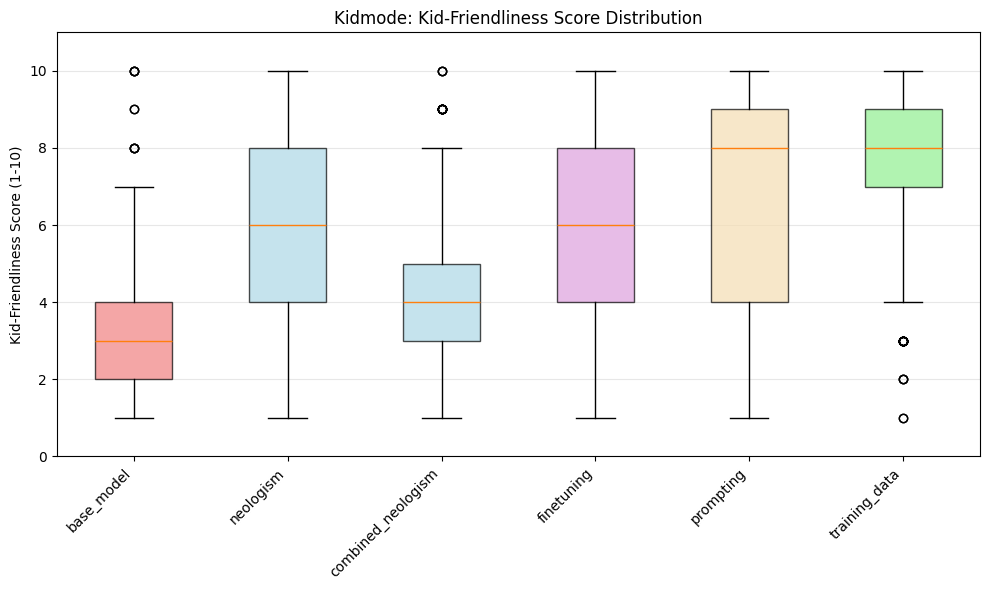


Box plot saved to kidmode_score_boxplot.png


In [33]:
# Box and whisker plot
fig2, ax2 = plt.subplots(figsize=(10, 6))

box_data = [kidmode_results[n]['scores'] for n in names]
bp = ax2.boxplot(box_data, labels=names, patch_artist=True)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_xticklabels(names, rotation=45, ha='right')
ax2.set_ylabel('Kid-Friendliness Score (1-10)')
ax2.set_title('Kidmode: Kid-Friendliness Score Distribution')
ax2.set_ylim(0, 11)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('kidmode_score_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nBox plot saved to kidmode_score_boxplot.png")

In [38]:
# ============================================================================
# GAP CLOSURE - (MEANS)
# Formula: (x_mean - base_mean) / (training_mean - base_mean)
# ============================================================================

def compute_gap_closure(results, mode_name="short"):
    base_mean = results['base_model']['mean']
    training_mean = results['training_data']['mean']
    denom = training_mean - base_mean

    if denom == 0:
        raise ValueError(f"{mode_name}: training_mean - base_mean is zero; gap closure undefined.")

    methods = ['neologism', 'combined_neologism', 'finetuning', 'prompting']
    gap_closure = {}

    print(f"\n{mode_name.upper()} MODE - GAP CLOSURE (MEAN)")
    print(f"Base mean:     {base_mean:.4f}")
    print(f"Training mean: {training_mean:.4f}")
    print(f"Denominator:   {denom:.4f}\n")

    print(f"{'Method':<20} {'Gap Closure':>12}")
    print("-" * 32)

    for m in methods:
        x_mean = results[m]['mean']
        gc = (x_mean - base_mean) / denom
        gap_closure[m] = gc
        print(f"{m:<20} {gc:>12.4f}")

    return gap_closure

short_gap_closure_mean = compute_gap_closure(short_results, mode_name="short")
kidmode_gap_closure_mean = compute_gap_closure(kidmode_results, mode_name="kidmode")




SHORT MODE - GAP CLOSURE (MEAN)
Base mean:     303.1367
Training mean: 41.2067
Denominator:   -261.9300

Method                Gap Closure
--------------------------------
neologism                  0.9550
combined_neologism         0.8454
finetuning                -0.1647
prompting                  0.9485

KIDMODE MODE - GAP CLOSURE (MEAN)
Base mean:     2.9967
Training mean: 7.5500
Denominator:   4.5533

Method                Gap Closure
--------------------------------
neologism                  0.6918
combined_neologism         0.2343
finetuning                 0.6032
prompting                  0.8572


In [39]:
# ============================================================================
# GAP CLOSURE - SHORT (FT MEDIAN, OTHERS MEAN)
# Formula: (x_value - base_mean) / (training_mean - base_mean)
# - finetuning uses median
# - all other methods use mean
# ============================================================================

def compute_gap_closure_short_ft_median(results):
    base_mean = results['base_model']['mean']
    training_mean = results['training_data']['mean']
    denom = training_mean - base_mean

    if denom == 0:
        raise ValueError("short (FT median): training_mean - base_mean is zero; gap closure undefined.")

    methods = ['neologism', 'combined_neologism', 'finetuning', 'prompting']
    gap_closure = {}

    print("\nSHORT MODE - GAP CLOSURE (FT MEDIAN, OTHERS MEAN)")
    print(f"Base mean:     {base_mean:.4f}")
    print(f"Training mean: {training_mean:.4f}")
    print(f"Denominator:   {denom:.4f}\n")

    print(f"{'Method':<25} {'Value Used':>12} {'Gap Closure':>14}")
    print("-" * 55)

    for m in methods:
        if m == 'finetuning':
            x_value = results[m]['median']
        else:
            x_value = results[m]['mean']

        gc = (x_value - base_mean) / denom
        gap_closure[m] = gc
        print(f"{m:<25} {x_value:>12.4f} {gc:>14.4f}")

    return gap_closure

short_gap_closure_ft_median = compute_gap_closure_short_ft_median(short_results)



SHORT MODE - GAP CLOSURE (FT MEDIAN, OTHERS MEAN)
Base mean:     303.1367
Training mean: 41.2067
Denominator:   -261.9300

Method                      Value Used    Gap Closure
-------------------------------------------------------
neologism                      52.9900         0.9550
combined_neologism             81.7000         0.8454
finetuning                     75.5000         0.8691
prompting                      54.7033         0.9485
